<a href="https://colab.research.google.com/github/Yeonsu-Hong/Aiffel_Daegu_AI_project/blob/master/Going_deeper_8_Object_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 8-9. 프로젝트: 자율주행 보조 시스템 만들기

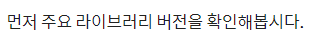

In [3]:
import tensorflow as tf

print(tf.__version__)

2.8.0


In [30]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.6.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.6.0


In [31]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 48 kB/s 
     |████████████████████████████████| 2.9 MB 84.6 MB/s 
     |████████████████████████████████| 459 kB 91.0 MB/s 
     |████████████████████████████████| 20.1 MB 759 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6209, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6209 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6209/6209), 13.48 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (4200/4200), done.


In [2]:
!cd keras-retinanet && python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -

**0. 전반적인 선행과정 수행**

In [4]:
!mkdir -p ~/aiffel/object_detection/data

이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 탐지되었을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 크기 이상일 때를 판단해야 한다.

자율주행 보조 장치 object detection 요구사항

1) 사람이 카메라에 감지되면 정지

2) 차량이 일정 크기 이상으로 감지되면 정지

tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용해본다.

KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨을 제공한다.

In [5]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'


In [6]:
# 필요한 라이브러리 설치
!pip install gdrive_dataset

In [7]:
# 40분에서 1시간 가량 걸린다.

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir = DATA_PATH,
    split = ['train','test'],
    shuffle_files = True,
    with_info = True,
)

* 복습 : 파이썬 언더스코어(_) 사용할때의 의미

1. 인터프리터(Interpreter)에서 마지막 값을 저장할 때
2. 값을 무시하고 싶을때
3. 변수나 함수명에 특별한 의미 또는 기능을 부여하고자 할 때
4. 국제화(Internationalization, i18n)/지역화(Localization, l10n) 함수로써 사용할 때
5. 숫자 리터럴값의 자릿수 구분을 위한 구분자로써 사용할 때

아래 예시에서는 변수나 함수명에 특별한 의미 또는 기능을 부여하고자 하여 사용된 것 같다.



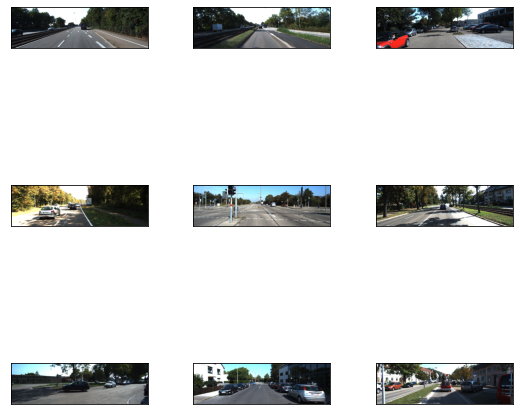

In [8]:
_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 ds_info 에서는 불러온 데이터셋의 정보를 확인할 수 있다.

사용할 데이터셋은 6,347개의 학습 데이터, 711개의 평가용 데이터, 432개의 검증용 데이터로 구성되어 있다.

라벨(클래스)에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있다.


In [9]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

데이터 직접 확인하기

--------Example-------
['image', 'image/file_name', 'objects']
-------objects--------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.54,  2.42, -0.47, -0.18,  2.75], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.40968   , 0.456095  , 0.4948    , 0.48332527],
       [0.00266667, 0.74169886, 0.53061336, 0.99919486],
       [0.16170667, 0.6862077 , 0.52301335, 0.99919486],
       [0.32341334, 0.59747183, 0.51405334, 0.7723833 ],
       [0.22856   , 0.65558773, 0.52      , 0.8912721 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.43, 1.55, 3.91],
       [1.51, 1.65, 4.21],
       [1.48, 1.49, 4.16],
       [1.51, 1.69, 4.42],
       [1.56, 1.5 , 3.8 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-1.3 ,  2.28, 35.72],
       [ 5.11,  1.54,  6.24],
       [ 5.23,  1.58,  8.75],
       [ 5.26,  1.75, 16.39],
       [ 5.25,  1.69, 11.24]], dtype=float32)

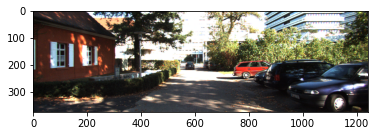

In [10]:
sample = ds_train.take(1)

for example in sample:
  print('--------Example-------')
  print(list(example.keys()))
  image = example['image']
  filename = example['image/file_name'].numpy().decode('utf-8')
  objects = example['objects']

print('-------objects--------')
print(objects)


img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

이미지와 라벨을 얻는 방법을 알게 되었다. 
이미지의 바운딩 박스(bounding bix, bbox)를 확인하기 위해서는 어떻게 해야 할까?


In [11]:
'''
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
'''

"\n데이터셋 이해를 위한 예시\nValues    Name      Description\n----------------------------------------------------------------------------\n   1    type         Describes the type of object: 'Car', 'Van', 'Truck',\n                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',\n                     'Misc' or 'DontCare'\n   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where\n                     truncated refers to the object leaving image boundaries\n   1    occluded     Integer (0,1,2,3) indicating occlusion state:\n                     0 = fully visible, 1 = partly occluded\n                     2 = largely occluded, 3 = unknown\n   1    alpha        Observation angle of object, ranging [-pi..pi]\n   4    bbox         2D bounding box of object in the image (0-based index):\n                     contains left, top, right, bottom pixel coordinates\n   3    dimensions   3D object dimensions: height, width, length (in meters)\n   3    location     3D object location x,

https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html

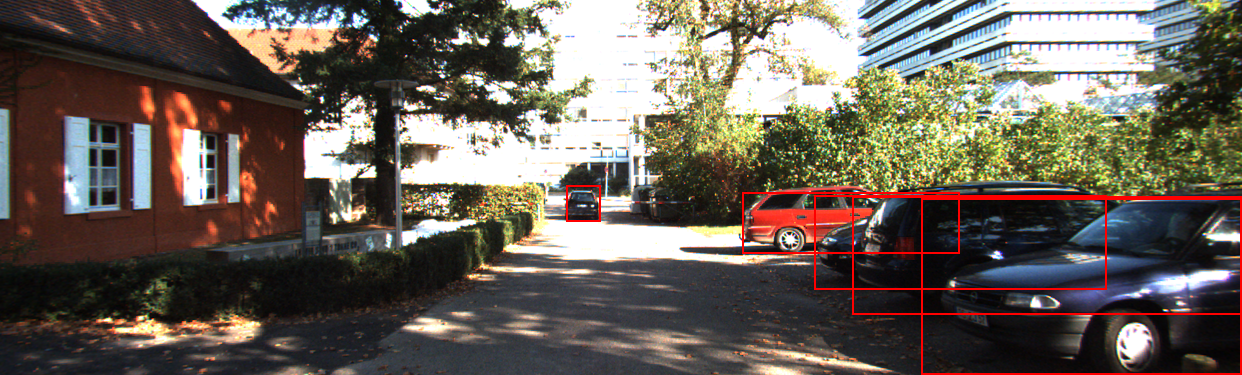

In [12]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시

def visualize_bbox(input_image, object_bbox):
  input_image = copy.deepcopy(input_image)
  draw = ImageDraw.Draw(input_image)

  # 바운딩 박스 좌표(x_min, x_max, y_min, y_max)
  width, height = img.size
  x_min = object_bbox[:, 1] * width
  x_max = object_bbox[:, 3] * width
  y_min = height - object_bbox[:, 0] * height
  y_max = height = object_bbox[:, 2] * height

  # 바운딩 박스 그리기
  rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
  for _rect in rects:
    draw.rectangle(_rect, outline=(255,0,0), width=2)

  return input_image

visualize_bbox(img, objects['bbox'].numpy())

RetinaNet 

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 잇었다. 이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network)를 적용한 네트워크를 사용한다.

Receptive field (수용영역, 수용장)은 출력 layer의 뉴런 하나에 영향을 미치는 입력 뉴런 하나에 영향을 미치는 입력 뉴런들의 공간 크기이다. 

Focal Loss : 물체를 배경보다 더 잘 학습하자 == 물체인 경우 Loss를 작게 만들자. 

Focal loss는 우리가 많이 사용해왔던 교차 엔트로피 기반으로 만들어 졌다. 위 그림을 보면 Focal loss는 그저 교차 엔트로피의 앞단에 간단히 (1 - pt)^r라는 modulating factor를 붙여 주었다.

교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류되는 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있다.
하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어진다.

이 상황은 물체 검출 모델을 학습시키는 과정에서 문제가 될 수 있다. 대부분의 이미지에서는 물체보다 배경이 많다.

따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있다.

이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해준다.
r를 0으로 설정하면 modulating factor가 1이 되어 일반적인 교차 엔트로피가 되고 r가 커질수록 modulating이 강하게 적용되는 것을 확인할 수 있다.



- FPN (Feature Pyramid Network)

여러 층의 특성 맵(feature map)을 다 사용해보자


데이터 파이프라인

-> 먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야한다. 이때 사용할 데이터 파이프라인을 구축한다.

데이터 준비

데이터 파이프라인 총 4단계

1. x와 y 좌표 위치 교체
2. 무작위로 수평 뒤집기(flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [13]:
import tensorflow as tf 
from tensorflow import keras

https://shakeratos.tistory.com/65

In [14]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [15]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

In [16]:
import pandas as pd
from tqdm import tqdm


In [17]:
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df
    
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [18:32<00:00,  5.70it/s]


In [18]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [02:10<00:00,  5.44it/s]


In [24]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

In [26]:
!pip install --user git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-11z9ru5p
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-11z9ru5p
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264902 sha256=a1635c64710d5885d4121c439491798aa3727b8a0753b137efaedd103bfc0fa8
  Stored in directory: /tmp/pip-ephem-wheel-cache-iz5kyl8m/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [28]:
!keras_retinanet/utils/keras_version.py

/bin/bash: keras_retinanet/utils/keras_version.py: No such file or directory


In [30]:
print(keras.__version__)

2.4.0


In [31]:
!pip install keras==2.2.4

  Using cached Keras-2.2.4-py2.py3-none-any.whl (312 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [38]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [35]:
!cd keras-retinanet && python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [36]:
# !cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt


python3: can't open file 'keras-retinanet/keras_retinanet/bin/train.py': [Errno 2] No such file or directory


In [39]:
import random
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu
from keras_retinanet.models import load_model
from keras_retinanet.utils.colors import label_color
import os
import pydicom
import cv2

import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

ModuleNotFoundError: ignored

[keras-retinanet/train.py 원본 소스코드](https://github.com/fizyr/keras-retinanet/blob/main/keras_retinanet/bin/train.py)

In [21]:
# !python ~/aiffel/object_detection/data/kitti/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_10.h5 ./snapshots/resnet50_csv_50_infer.h5

In [33]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: ignored

In [ ]:
import os
img_path = 'data/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

In [ ]:
img_path = 'data/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

In [ ]:
img_path = 'data/test_set/stop_3.png'

def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # 만약 사람이 1명 이상이면 멈춘다.
        if label == 1:
            return "Stop"
        
        elif label == 0:
            width = box[2] - box[0]
            height = box[3] - box[1]
            # 사람이 아닌 경우 width와 height 둘 중 하나가 300 이상이면 'Stop'
            if width > 300 or height > 300:
                return "Stop"
        # 둘다 아니라면 그냥 간다.    
        if score < 0.5:
            return "Go"

print(self_drive_assist(img_path)) 

In [ ]:
import os

def test_system(func):
    work_dir = 'data/'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

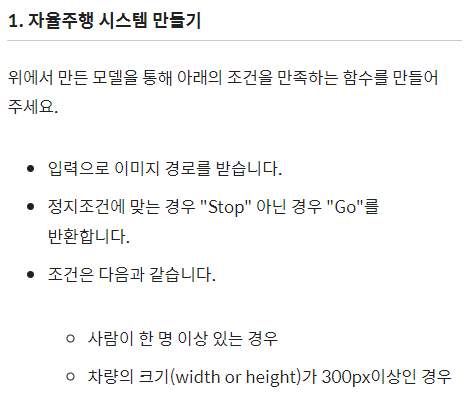

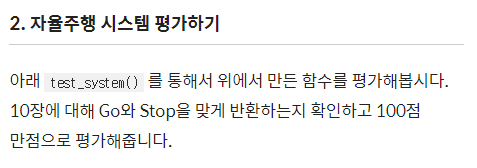

In [ ]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)